In [4]:
import pandas as pd
import os

In [5]:
from __future__ import print_function
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/drive.file']

def create_service():
    """Shows basic usage of the Docs API.
    Prints the title of a sample document.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                '/home/sergiov/Downloads/client_secret_523128072497-80o6vkcpc0ecgum1fa59lhhb88h6s7ir.apps.googleusercontent.com (1).json', SCOPES)
            creds = flow.run_local_server()
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('docs', 'v1', credentials=creds)

    return service

In [61]:
def create_table(rows, columns, table_index):
    table_body = {
        "insertTable":
            {
                "rows": rows,
                "columns": columns,
                "location":
                    {
                        "index": table_index
                    }
            }
    }
    return table_body

def insert_table_data(rows, columns, text):
    table_data = []
    for i in reversed(range(rows)):
        inp_text = text[i]
        rowIndex = (i+1)*5
        for j in reversed(range(columns)):
            index = rowIndex + (j*2)
            insert_value = {
                "insertText":
                    {
                        "text": inp_text[j],
                        "location":
                            {
                                "index": index
                            }
                    }

            }
            table_data.append(insert_value)

    print(table_data)
    return table_data

def create_document(service, title):
    body = {'title': title}
    doc = service.documents().create(body=body).execute()
    title = doc.get('title')
    _id = doc.get('documentId')
    print(f'Created document with title: {title}, id: {_id}')

    return _id

def insert_title(service, file_id, content):
    requests = [
        {
            'insertText': {
                'text': f'\n{content}\n',
                'location': {
                    'index': 1,
                },
            },
        },
        {
            'updateParagraphStyle': {
                'paragraphStyle': {
                    'namedStyleType': 'HEADING_2',
                },
                'range': {
                    'startIndex': 2,
                    'endIndex': len(content) + 2,
                },
                'fields': 'namedStyleType',
            },
        },
    ]

    service.documents().batchUpdate(documentId=file_id, body={'requests': requests}).execute()

def insert_text(service, file_id, content):
    requests = [
        {
            'insertText': {
                'text': f'{content}',
                'location': {
                    'index': 1,
                },
            }
        }
    ]

    # Execute the requests
    service.documents().batchUpdate(documentId=file_id, body={'requests': requests}).execute()

def insert_feature_importances_table(service, file_id, importances_1, importances_2):
    requests = []

    requests.append(create_table(2, 2, 1))

    text = [['Importances train test', 'Importances internal validation'], [importances_1, importances_2]]
    requests.append(insert_table_data(2, 2, text))

    service.documents().batchUpdate(documentId=file_id, body={'requests': requests}).execute()


Converted dictionary: {'target': 'Response', 'features': ['TMB_zscore', 'HLA-I.GSVA', 'HLA-II.GSVA', 'CD8_T_eff_Mariathasan.GSVA', 'Chemokine_12.GSVA', 'IFNg_Ayers.GSVA', 'Stroma_EMT.GSVA', 'T_cell_inflamed.GSVA', 'TGF_beta.GSVA', 'VIGex.GSVA'], 'scaler': 'min_max', 'encoder': 'one_hot', 'class_balancer': '', 'split_validation': True, 'model': 'xgboost', 'enable_parameter_search': True, 'splitting_runs': 100, 'bootstrap_runs': 100, 'output_file': 'test.csv'}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


/home/sergiov/PycharmProjects/ICB_Response_Model/venv/lib/python3.8/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/sergiov/PycharmProjects/ICB_Response_Model/venv/lib/python3.8/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


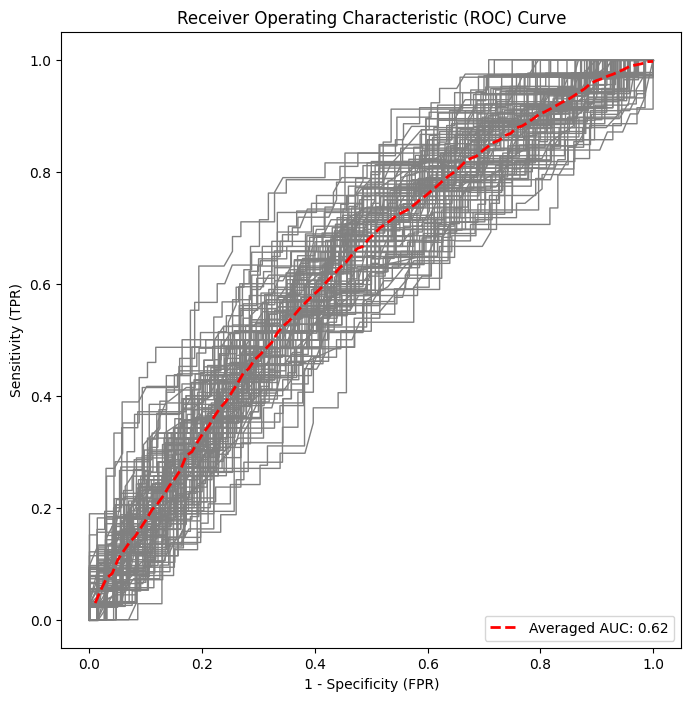

In [7]:
import main
import sys
import pandas as pd

sys.argv = ['/home/sergiov/Desktop/full_data_random.csv','/home/sergiov/PycharmProjects/ICB_Response_Model/parameters']

main.main()

df = pd.read_csv('test.csv')

In [24]:
df.columns

Index(['Unnamed: 0', '0'], dtype='object')

In [55]:
import ast
from collections import OrderedDict

row_name = 'feature_importances'
column_name = 'Unnamed: 0'
train_test_features = df.loc[df[column_name] == row_name, '0'].iloc[0]

dict_str = train_test_features.replace("OrderedDict", "")

# Using ast.literal_eval to convert the string to an OrderedDict
ordered_dict = ast.literal_eval(dict_str)

# Converting to an actual OrderedDict
ordered_dict = OrderedDict(ordered_dict)

features_text = '\n'.join(f'{key}: {value}' for key, value in ordered_dict.items())

In [56]:
features_text

'TMB_zscore: 0.15\nIFNg_Ayers.GSVA: 0.116\nCD8_T_eff_Mariathasan.GSVA: 0.104\nHLA-I.GSVA: 0.103\nT_cell_inflamed.GSVA: 0.1\nTGF_beta.GSVA: 0.1\nChemokine_12.GSVA: 0.09\nVIGex.GSVA: 0.09\nHLA-II.GSVA: 0.079\nStroma_EMT.GSVA: 0.069'

In [57]:
service = create_service()

title = 'diary 1'
file_id = create_document(service, title)

Created document with title: diary 1, id: 1Fm0p8i1Y-I2idxg7d1_j_R5w0jd_cktDcq2cIj9w9Gk


In [64]:
insert_feature_importances_table(service, file_id, features_text,features_text)

[{'insertText': {'text': 'TMB_zscore: 0.15\nIFNg_Ayers.GSVA: 0.116\nCD8_T_eff_Mariathasan.GSVA: 0.104\nHLA-I.GSVA: 0.103\nT_cell_inflamed.GSVA: 0.1\nTGF_beta.GSVA: 0.1\nChemokine_12.GSVA: 0.09\nVIGex.GSVA: 0.09\nHLA-II.GSVA: 0.079\nStroma_EMT.GSVA: 0.069', 'location': {'index': 12}}}, {'insertText': {'text': 'TMB_zscore: 0.15\nIFNg_Ayers.GSVA: 0.116\nCD8_T_eff_Mariathasan.GSVA: 0.104\nHLA-I.GSVA: 0.103\nT_cell_inflamed.GSVA: 0.1\nTGF_beta.GSVA: 0.1\nChemokine_12.GSVA: 0.09\nVIGex.GSVA: 0.09\nHLA-II.GSVA: 0.079\nStroma_EMT.GSVA: 0.069', 'location': {'index': 10}}}, {'insertText': {'text': 'Importances internal validation', 'location': {'index': 7}}}, {'insertText': {'text': 'Importances train test', 'location': {'index': 5}}}]


In [59]:
row_name = 'auc'
column_name = 'Unnamed: 0'
auc = df.loc[df[column_name] == row_name, '0'].iloc[0]

text = f"AUC value for train/test is: {auc}"

insert_text(service, file_id, text)

In [62]:
row_name = 'sample_size'
column_name = 'Unnamed: 0'
sample_size = df.loc[df[column_name] == row_name, '0'].iloc[0]

text = f"Sample size is: {sample_size}"

insert_text(service, file_id, text)

In [63]:
insert_title(service, file_id, 'Model 1')